Authors
* Kush **Gupta**, kushg1121@gmail.com
* Sebestyén **Németh**, nemeth.sbn@gmail.com

In [ ]:
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from math import sqrt, floor

In [ ]:
!mkdir -p images
!wget -q https://people.math.sc.edu/Burkardt/data/tif/cameraman.tif -O images/cameraman.tif
!wget -q https://www.math.u-bordeaux.fr/~jaujol/code/Im1.png -O images/Im1.png
!wget -q https://www.math.u-bordeaux.fr/~jaujol/code/Im2.png -O images/Im2.png
!wget -q https://www.math.u-bordeaux.fr/~jaujol/code/Im3.png -O images/Im3.png
!wget -q https://www.math.u-bordeaux.fr/~jaujol/code/Im1_mask.png -O images/Im1_mask.png
!wget -q https://www.math.u-bordeaux.fr/~jaujol/code/Im2_mask.png -O images/Im2_mask.png
!wget -q https://www.math.u-bordeaux.fr/~jaujol/code/Im3_mask.png -O images/Im3_mask.png


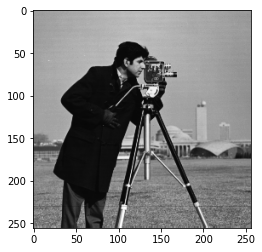

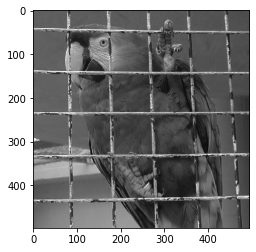

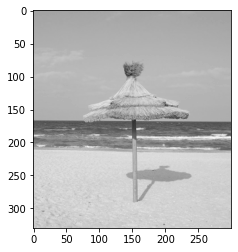

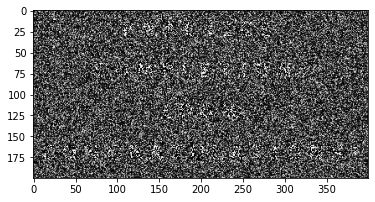

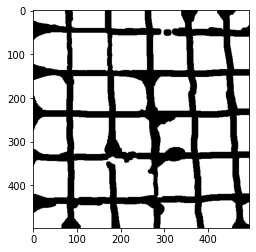

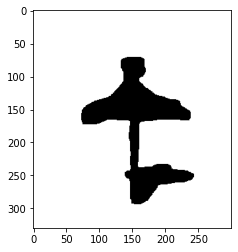

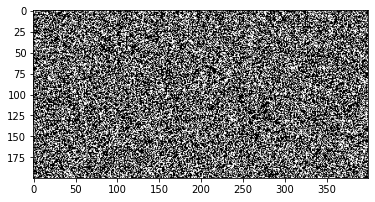

In [ ]:
Im_PIL = Image.open('images/cameraman.tif')
Im_data = np.array(Im_PIL)

Im1 = np.array(Image.open('images/Im1.png')).astype(np.float64)
Im2 = np.array(Image.open('images/Im2.png')).astype(np.float64)
Im3 = np.array(Image.open('images/Im3.png')).astype(np.float64)

Im1_mask = np.array(Image.open('images/Im1_mask.png')).astype(np.float64)
Im2_mask = np.array(Image.open('images/Im2_mask.png')).astype(np.float64)
Im3_mask = np.array(Image.open('images/Im3_mask.png')).astype(np.float64)

bounds = {'vmin': 0, 'vmax': 255}

plt.imshow(Im_data, cmap='gray', **bounds)
plt.show()
plt.imshow(Im1, cmap='gray', **bounds)
plt.show()
plt.imshow(Im2, cmap='gray', **bounds)
plt.show()
plt.imshow(Im3, cmap='gray', **bounds)
plt.show()

plt.imshow(Im1_mask, cmap='gray', **bounds)
plt.show()
plt.imshow(Im2_mask, cmap='gray', **bounds)
plt.show()
plt.imshow(Im3_mask, cmap='gray', **bounds)
plt.show()

In [ ]:
def add_gaussian_noise(I, s):
  m, n = I.shape
  I_out = I + s * np.random.randn(m, n)
  return I_out # np.clip(I_out, 0, 255)

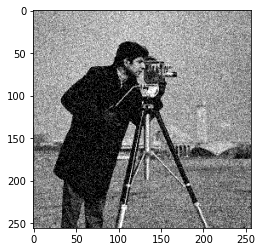

In [ ]:
Im_noised = add_gaussian_noise(Im_data, s=30)
plt.imshow(Im_noised, cmap='gray', **bounds)
plt.show()

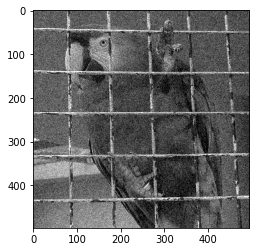

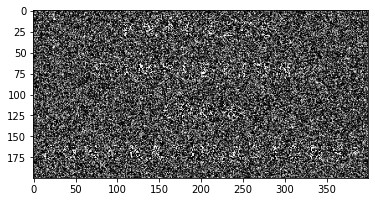

In [ ]:
Im_noised1 = add_gaussian_noise(Im1, s=30)
plt.imshow(Im_noised1, cmap='gray', **bounds)
plt.show()
Im_noised3 = add_gaussian_noise(Im3, s=30)
plt.imshow(Im_noised3, cmap='gray', **bounds)
plt.show()

Proximal operator

In [ ]:
def scalar_product(u, v):
  return np.dot(u, v)

def norm(u):
  return np.linalg.norm(u, axis=0)

def gradient(u):
  m, n = u.shape
  grad_u = np.zeros((2, m, n))
  
  grad_u[0, :-1, :] = u[1:] - u[:-1]
  
  grad_u[1, :, :-1] = u[:, 1:] - u[:, :-1]
  
  return grad_u
  
def div(p):
  m, n = p.shape[1:]
  
  div_1 = np.zeros((m, n))
  div_1[:-1, :] = p[0, :-1, :]
  div_1[1:, :] -= p[0, :-1, :]
  
  div_2 = np.zeros((m, n))
  div_2[:, :-1] = p[1, :, :-1]
  div_2[:, 1:] -= p[1, :, :-1]
  
  return div_1 + div_2

In [ ]:
def laplacian(u):
  return div(gradient(u))

In [ ]:
def MSE(f, u):
  return ((f - u)**2).mean()
def PSNR(f, u):
  return 20 * np.log10(np.max(f)) - 10 * np.log10(MSE(f, u))

In [ ]:
def proximal(u,h,x,F):
  return np.argmin((norm(u-x)^2 / 2 * h) + F)

In [ ]:
def add_gaussian_noise(I, s):
  m, n = I.shape
  I_out = I + s * np.random.randn(m, n)
  return I_out

In [ ]:
#F1 = 0.5 * norm(u)^2
def prox_F1(x,h):
  return (x/1+h)

In [ ]:
#F2 = 0.5 * norm(u - f)^2
def prox_F2(x,h,f):
  return( x + h*f / 1+h )

In [ ]:
#F4 = norm(u) 
def prox_F4(x,h,l,f=None):
  if f is None:
    f = np.zeros_like(x)
  u = np.zeros_like(x)
  m = x > (f + h * l)
  u[m] = (x - h * l)[m]
  m = x < (f - h * l)
  u[m] = (x + h * l)[m]
  m = np.abs(x - f) <= h * l
  u[m] = f[m]

  return u

In [ ]:
# F5 = norm(grad(u)) 
def Pc(z):
  # if np.max(norm(z)) <= 1:
  #  return z
  # return z / norm(z)
  norm_z = norm(z)
  z[:, norm_z > 1] /= norm_z[norm_z > 1]
  return z

def prox_F5(x,h,tau=0.1):
  z = np.zeros_like(gradient(x))
  for _ in range(100):
    z = Pc(z - tau * (-2 * gradient(div(z) + x/h)))
  return x + h * div(z)

# 2.2 Forward backward Algorithm

In [ ]:
def forward_backward_algo(f,h,K,tau,grad_f,prox_fn):
  u = np.zeros_like(f)
  for k in range(K):
    u_new = prox_fn(u - h * grad_f(u, f),tau=tau,h=h)
    #print(MSE(u, u_new))
    u = u_new
    
  return u

In [ ]:
Im_rec = forward_backward_algo(
    f=Im_noised,
    h=0.5,
    K=200,
    tau=0.5,
    grad_f=lambda x, f: 2 * 0.05 * (x - f),
    prox_fn=prox_F5)

In [ ]:
#Im_rec1 = forward_backward_algo(Im_noised1,0.1,100)

In [ ]:
#Im_rec3 = forward_backward_algo(Im_noised3,0.1,100)

In [ ]:
def fb_output(Im_data,Im_rec,Im_noised):
  #print(Im_rec.min(), Im_rec.max())
  #print(Im_noised.min(), Im_noised.max())
  #print(Im_data.min(), Im_data.max())
  normed = Im_rec # 255 * (Im_rec - Im_rec.min()) / (Im_rec.max() - Im_rec.min())
  plt.imshow(normed, cmap='gray', **bounds)
  print('PSNR Rec Image:', PSNR(normed, Im_data))
  plt.show()

PSNR Rec Image: 24.736823663932427


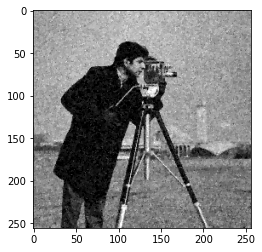

In [ ]:
fb_output(Im_data,Im_rec,Im_noised)
#fb_output(Im1,Im_rec1,Im_noised1)
#fb_output(Im3,Im_rec3,Im_noised3)

In [ ]:
import itertools
import pandas as pd

sigma_list = [10, 20, 30]
h_list = [0.1, 0.5]
num_of_iter_list = [50, 100, 200]
lamb_list = [0.05, 0.1]

results_dict = dict()

for sigma in sigma_list:
  _result_list = []

  for h, K, lamb in tqdm(list(itertools.product(h_list, num_of_iter_list, lamb_list))):
    _Im_noised = add_gaussian_noise(Im_data, s=sigma)
    Im_rec = forward_backward_algo(
      f=_Im_noised,
      h=h,
      K=K,
      tau=h,
      grad_f=lambda x, f: 2 * lamb * (x - f),
      prox_fn=prox_F5)
    _result_list.append({
        'h': h,
        'K': K,
        'lamb': lamb,
        'PSNR': PSNR(Im_rec, Im_data)
    })

  df = pd.DataFrame(_result_list)
  results_dict[sigma] = df
  print("sigma", sigma)
  print(df.sort_values(by='PSNR', ascending=False).head(5))

  0%|          | 0/12 [00:00<?, ?it/s]<ipython-input-52-b87df031797c>:5: RuntimeWarning: invalid value encountered in true_divide
  return z / norm(z)
100%|██████████| 12/12 [06:28<00:00, 32.38s/it]


sigma 10
      h    K  lamb       PSNR
11  0.5  200  0.10  32.812021
7   0.5   50  0.10  32.730801
9   0.5  100  0.10  32.673347
5   0.1  200  0.10  31.866090
10  0.5  200  0.05  31.023054


  0%|          | 0/12 [00:00<?, ?it/s]<ipython-input-52-b87df031797c>:5: RuntimeWarning: invalid value encountered in true_divide
  return z / norm(z)
100%|██████████| 12/12 [06:31<00:00, 32.59s/it]


sigma 20
      h    K  lamb       PSNR
10  0.5  200  0.05  28.516784
8   0.5  100  0.05  28.308920
9   0.5  100  0.10  26.679183
5   0.1  200  0.10  26.418965
11  0.5  200  0.10  26.390184


  0%|          | 0/12 [00:00<?, ?it/s]<ipython-input-52-b87df031797c>:5: RuntimeWarning: invalid value encountered in true_divide
  return z / norm(z)
100%|██████████| 12/12 [06:26<00:00, 32.17s/it]

sigma 30
      h    K  lamb       PSNR
10  0.5  200  0.05  26.129980
8   0.5  100  0.05  24.537068
9   0.5  100  0.10  23.314136
6   0.5   50  0.05  23.083822
7   0.5   50  0.10  22.866369


FISTA

In [ ]:
def FISTA(f, h, K, tau, prox_fn, grad_F, f_orig=None, verbose=True):
  psnr = list()
  x = np.zeros_like(f)
  x_next = x.copy()
  t = 1
  t_next = t
  y = x.copy()
  iter_range = tqdm(range(K)) if verbose else range(K)
  for iter_idx in iter_range:
    x_next = prox_fn(y - h * grad_F(y, f), tau=tau, h=h)
    t_next = (1 + sqrt(1 + 4 * t**2)) / 2
    y = x_next + ((t - 1) / t_next) * (x_next - x)
    x = x_next
    t = t_next

    if f_orig is not None:
      psnr.append(PSNR(f_orig, x))
    
  if f_orig is not None:
   return x, psnr 
  
  return x

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-16-b87df031797c>:5: RuntimeWarning: invalid value encountered in true_divide
  return z / norm(z)
100%|██████████| 50/50 [00:06<00:00,  7.17it/s]


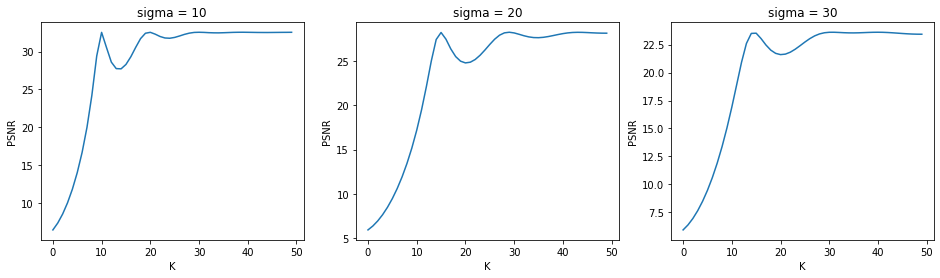

In [ ]:
h=[0.5]*3
K=[50]*3
lamb=[0.1,0.05,0.05]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
for i, sigma in enumerate([10, 20, 30]):
  _Im_noised = add_gaussian_noise(Im_data, s=sigma)
  Im_rec_FISTA, psnr_list = FISTA(
      _Im_noised,
      h=h[i],
      K=K[i],
      tau=h[i],
      prox_fn=prox_F5,
      grad_F=lambda x, f: 2 * lamb[i] * (x - f),
      f_orig=Im_data)
  axs[i].set_title(f"sigma = {sigma}")
  axs[i].set_xlabel("K")
  axs[i].set_ylabel("PSNR")
  axs[i].plot(psnr_list)
plt.show()

PSNR Rec Image: 23.152234411481466


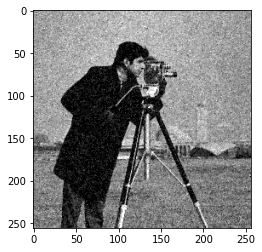

In [ ]:
fb_output(Im_data,Im_rec_FISTA,Im_noised)

#2.3 Image Restoration Salt and Pepper Noise

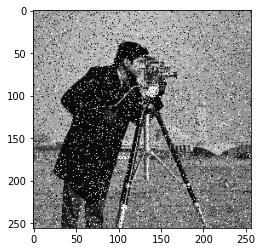

In [ ]:
def salt_and_peper_noise(Im, p):
  Im_out = Im.copy()
  mask = np.random.rand(Im_out.shape[0], Im_out.shape[1]) < p
  sp = np.random.randint(2, size=(Im_out.shape[0], Im_out.shape[1])) * 255
  Im_out[mask] = sp[mask]
  return Im_out
  
plt.imshow(salt_and_peper_noise(Im_data, 0.12), cmap='gray', vmin=0, vmax=255)
plt.show()

In [ ]:
def prox_cp(x, h, f, lamb):
  return x - h * prox_F4(x / h, h=1/h, f=f, l=lamb)

def chambolle_pock(f, K, lamb, h, prox_fn, verbose=True):
  u = np.zeros_like(f)
  u_t = np.zeros_like(f)
  y = np.zeros_like(f)
  iter_range = tqdm(range(K)) if verbose else range(K)
  for iter_idx in iter_range:
    y = prox_cp(y + h * u_t, h=h, f=f, lamb=lamb)
    u_next = prox_fn(u - h * y, tau=h, h=h)
    u_t = 2 * u_next - u
    u = u_next
  return u

In [ ]:
Im_noised_sp = salt_and_peper_noise(Im_data, 0.12)

Im_rec_cp = chambolle_pock(Im_noised_sp, 200, lamb=2, h=1, prox_fn=prox_F5)

100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


PSNR Rec Image: 26.625121503838464


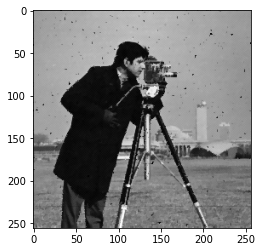

In [ ]:
fb_output(Im_data, Im_rec_cp, Im_noised_sp)

In [ ]:
import itertools
import pandas as pd

sigma_list = [0.05, 0.1, 0.15]
h_list = [0.5, 1, 2]
num_of_iter_list = [100, 200]
lamb_list = [1.5, 2]

results_dict = dict()

for sigma in sigma_list:
  _result_list = []

  for h, K, lamb in tqdm(list(itertools.product(h_list, num_of_iter_list, lamb_list))):
    _Im_noised_sp = salt_and_peper_noise(Im_data, sigma)
    Im_rec = chambolle_pock(
      f=_Im_noised_sp,
      h=h,
      K=K,
      lamb=lamb,
      prox_fn=prox_F5,
      verbose=False)
    _result_list.append({
        'h': h,
        'K': K,
        'lamb': lamb,
        'PSNR': PSNR(Im_rec, Im_data)
    })

  df = pd.DataFrame(_result_list)
  results_dict[sigma] = df
  print("sigma", sigma)
  print(df.sort_values(by='PSNR', ascending=False).head(5))

100%|██████████| 12/12 [23:06<00:00, 115.51s/it]


sigma 0.05
      h    K  lamb       PSNR
7   1.0  200   2.0  29.049547
11  2.0  200   2.0  27.840020
9   2.0  100   2.0  27.342109
6   1.0  200   1.5  26.322764
10  2.0  200   1.5  26.301314


100%|██████████| 12/12 [22:58<00:00, 114.85s/it]


sigma 0.1
      h    K  lamb       PSNR
7   1.0  200   2.0  27.517936
11  2.0  200   2.0  26.460653
9   2.0  100   2.0  26.063475
10  2.0  200   1.5  25.701672
6   1.0  200   1.5  25.501500


100%|██████████| 12/12 [21:45<00:00, 108.82s/it]

sigma 0.15
      h    K  lamb       PSNR
11  2.0  200   2.0  25.837116
7   1.0  200   2.0  25.836380
10  2.0  200   1.5  25.256750
9   2.0  100   2.0  24.558894
6   1.0  200   1.5  23.779504


PSNR Rec Image: 27.32824975029988


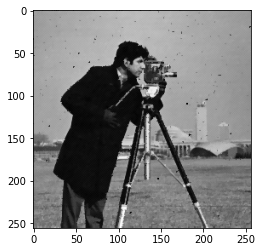

In [ ]:
# visualization

Im_noised_sp = salt_and_peper_noise(Im_data, 0.1)
Im_rec_cp = chambolle_pock(
  f=Im_noised_sp,
  h=1.0,
  K=200,
  lamb=2.0,
  prox_fn=prox_F5,
  verbose=False)
fb_output(Im_data, Im_rec_cp, Im_noised_sp)

# 2.4 Image deconvolution (gaussian noise)

In [ ]:
def gaussian_kernel(dt, K):
  P = floor(K * dt + 1)
  P_range = list(range(-P + 1, P))
  x, y = np.meshgrid(P_range, P_range)
  G = 1 / (4 * np.pi * K * dt) * np.exp(-(x**2 + y**2) / (4 * K * dt))
  G /= np.sum(G)
  return G

def convolve(f, G):
  return convolve2d(f, G, boundary='symm', mode='same')

In [ ]:
import itertools
import pandas as pd

sigma_list = [10, 20, 30]
h_list = [0.1, 0.5]
num_of_iter_list = [100, 200]
lamb_list = [0.05, 0.1]
G = gaussian_kernel(1/8, 1)

results_dict = dict()

for sigma in sigma_list:
  _result_list = []

  for h, K, lamb in tqdm(list(itertools.product(h_list, num_of_iter_list, lamb_list))):
    _Im_noised = add_gaussian_noise(Im_data, s=sigma)
    Im_rec = forward_backward_algo(
      f=_Im_noised,
      h=h,
      K=K,
      tau=h,
      grad_f=lambda x, f: -2 * lamb * convolve((f - convolve(x, G)), G.T),
      prox_fn=prox_F5)
    _result_list.append({
        'h': h,
        'K': K,
        'lamb': lamb,
        'PSNR': PSNR(Im_rec, Im_data)
    })

  df = pd.DataFrame(_result_list)
  results_dict[sigma] = df
  print("sigma", sigma)
  print(df.sort_values(by='PSNR', ascending=False).head(5))

100%|██████████| 8/8 [09:26<00:00, 70.77s/it]


sigma 10
     h    K  lamb       PSNR
5  0.5  100  0.10  32.706888
7  0.5  200  0.10  32.623187
3  0.1  200  0.10  31.897569
6  0.5  200  0.05  30.916491
4  0.5  100  0.05  30.850791


100%|██████████| 8/8 [09:52<00:00, 74.00s/it]


sigma 20
     h    K  lamb       PSNR
6  0.5  200  0.05  28.801524
4  0.5  100  0.05  28.654578
5  0.5  100  0.10  26.395903
7  0.5  200  0.10  26.348015
3  0.1  200  0.10  26.172747


100%|██████████| 8/8 [09:51<00:00, 73.88s/it]

sigma 30
     h    K  lamb       PSNR
6  0.5  200  0.05  25.164115
4  0.5  100  0.05  24.731155
7  0.5  200  0.10  23.117273
5  0.5  100  0.10  22.818352
3  0.1  200  0.10  22.408915


FISTA speedup

100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


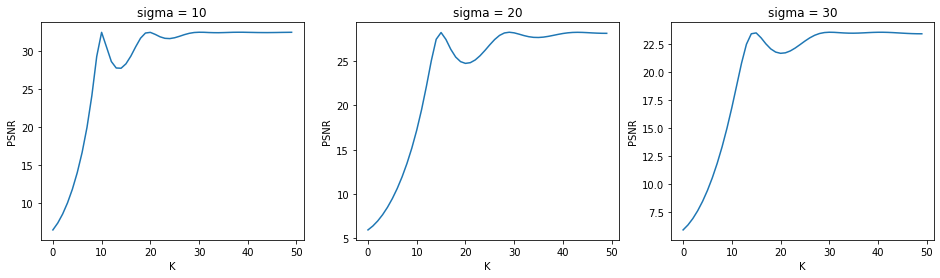

In [ ]:
h=[0.5]*3
K=[50]*3
lamb=[0.1,0.05,0.05]

G = gaussian_kernel(1/8, 1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
for i, sigma in enumerate([10, 20, 30]):
  _Im_noised = add_gaussian_noise(Im_data, s=sigma)
  Im_rec_FISTA, psnr_list = FISTA(
      _Im_noised,
      h=h[i],
      K=K[i],
      tau=h[i],
      prox_fn=prox_F5,
      grad_F=lambda x, f: -2 * lamb[i] * convolve((f - convolve(x, G)), G.T),
      f_orig=Im_data)
  axs[i].set_title(f"sigma = {sigma}")
  axs[i].set_xlabel("K")
  axs[i].set_ylabel("PSNR")
  axs[i].plot(psnr_list)
plt.show()

# Inpainting

100%|██████████| 3/3 [09:27<00:00, 189.01s/it]


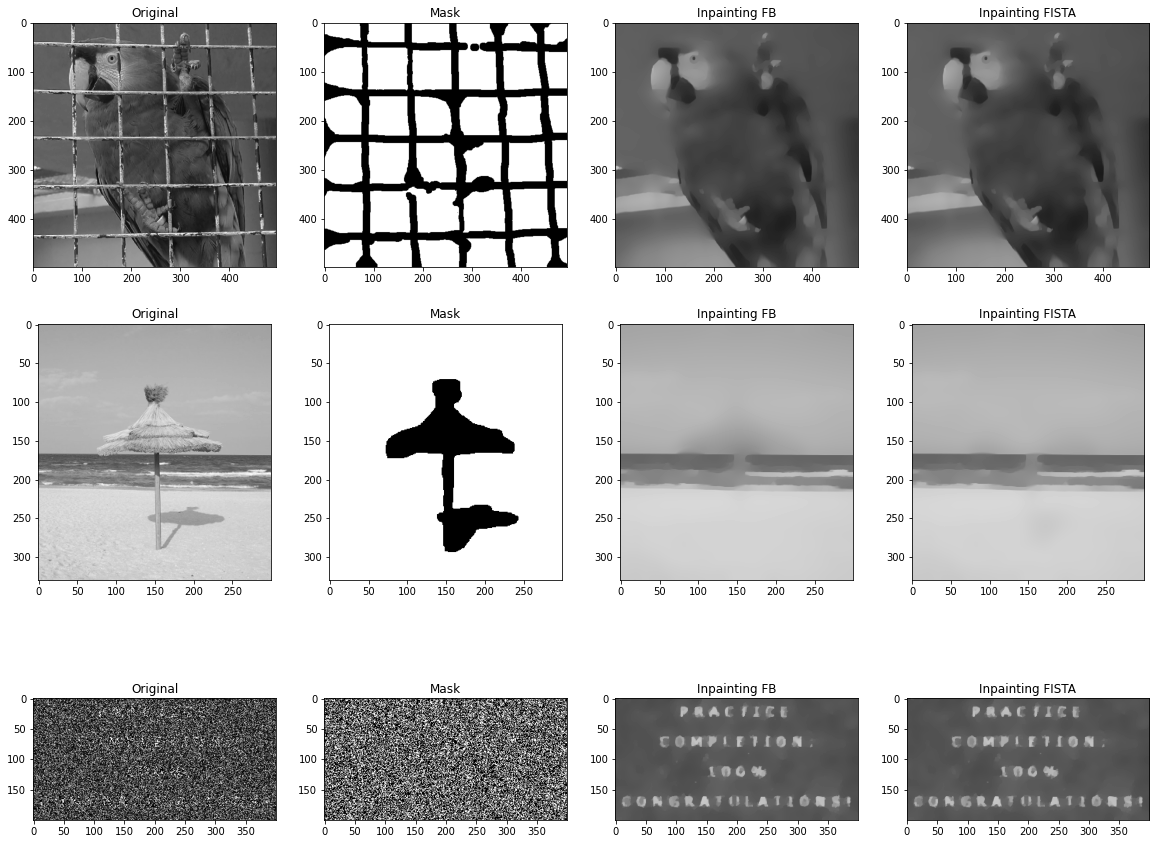

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20,16))
for i, (img, msk) in tqdm(list(enumerate(zip([Im1, Im2, Im3], [Im1_mask, Im2_mask, Im3_mask])))):
  axs[i][0].imshow(img, cmap='gray', **bounds)
  axs[i][0].set_title("Original")
  axs[i][1].imshow(msk, cmap='gray', **bounds)
  axs[i][1].set_title("Mask")

  h = 0.1
  lamb = 2
  
  grad_f = lambda x, f: -2 * lamb * np.where(msk, (f - np.where(msk, x, 0)), 0)
  
  img_ip = forward_backward_algo(
    f=img / 255,
    tau=h,
    h=h,
    K=200,
    grad_f=grad_f,
    prox_fn=prox_F5)

  axs[i][2].imshow(img_ip, cmap='gray', vmin=0, vmax=1)
  axs[i][2].set_title("Inpainting FB")

  img_ip_fista = FISTA(
    img / 255,
    h=h,
    K=40,
    tau=h,
    prox_fn=prox_F5,
    grad_F=grad_f,
    verbose=False)

  axs[i][3].imshow(img_ip_fista, cmap='gray', vmin=0, vmax=1)
  axs[i][3].set_title("Inpainting FISTA")